# CMI Code for Meshing and Clipping Subduction Zone

#### Libraries and necessary functions

In [97]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np # Numerical analysis
import gmsh # Creation of fault models
import meshio # Interaction between fault model files and Python
import matplotlib.pyplot as plt # Visualize 
from pyproj import Proj
import pyproj
import h5py
import scipy #for interpolation
from scipy.interpolate import NearestNDInterpolator 
from geopandas import geoseries
%matplotlib widget

In [98]:
# Define some basic coordinate transformation functions
GEOID = pyproj.Geod(ellps="WGS84")
KM2M = 1.0e3
RADIUS_EARTH = np.float64((GEOID.a + GEOID.b) / 2)

def sph2cart(lon, lat, radius):
    lon_rad = np.deg2rad(lon)
    lat_rad = np.deg2rad(lat)
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)
    z = radius * np.sin(lat_rad)
    return x, y, z

def cart2sph(x, y, z):
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return azimuth, elevation, r

def wrap2360(lon):
    lon[np.where(lon < 0.0)] += 360.0
    return lon

#### Read in subduction zone mesh and parse

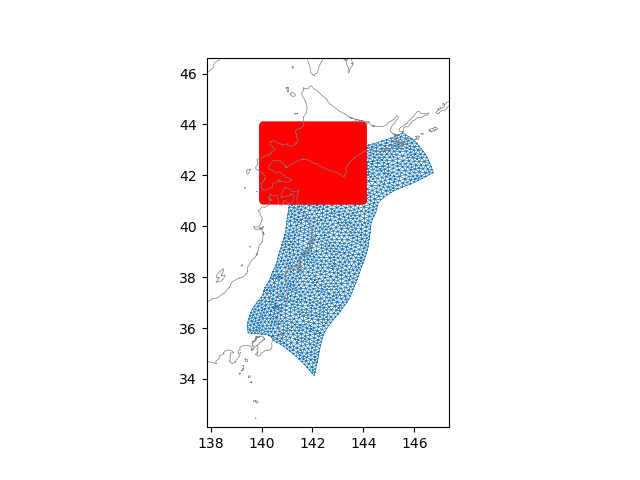

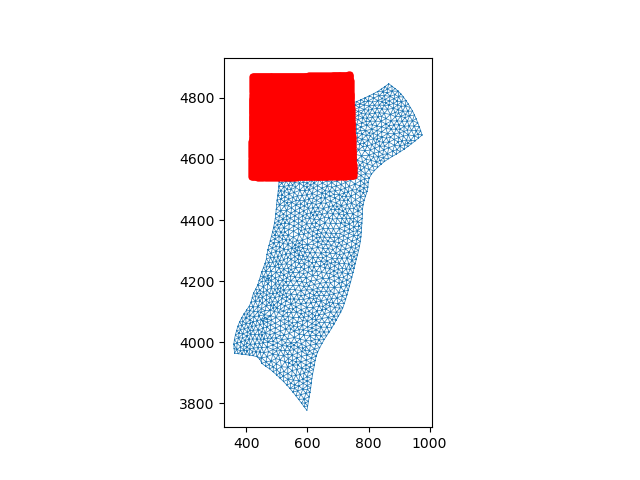

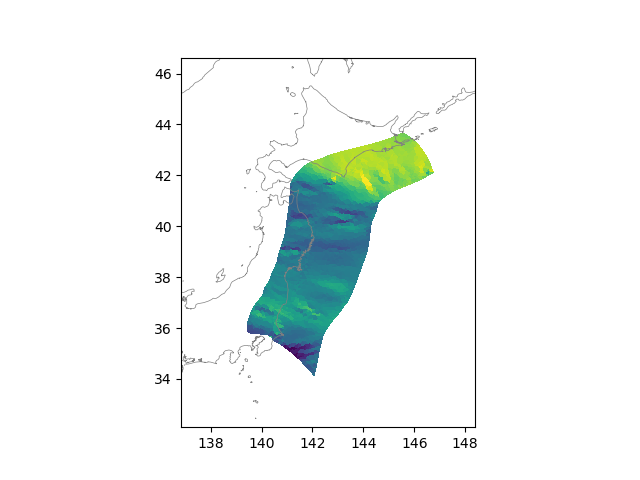

In [99]:
# Read in source fault
# filename = "cascadia.msh"
filename = "japan.msh"
mesh = dict()
meshobj = meshio.read(filename)
mesh["file_name"] = filename
mesh["points"] = meshobj.points
mesh["verts"] = meshio.CellBlock("triangle", meshobj.get_cells_type("triangle")).data
ntri = len(mesh["verts"])

# Expand mesh coordinates
mesh["lon1"] = mesh["points"][mesh["verts"][:, 0], 0]
mesh["lon2"] = mesh["points"][mesh["verts"][:, 1], 0]
mesh["lon3"] = mesh["points"][mesh["verts"][:, 2], 0]
mesh["lat1"] = mesh["points"][mesh["verts"][:, 0], 1]
mesh["lat2"] = mesh["points"][mesh["verts"][:, 1], 1]
mesh["lat3"] = mesh["points"][mesh["verts"][:, 2], 1]
mesh["dep1"] = mesh["points"][mesh["verts"][:, 0], 2]
mesh["dep2"] = mesh["points"][mesh["verts"][:, 1], 2]
mesh["dep3"] = mesh["points"][mesh["verts"][:, 2], 2]
mesh["centroids"] = np.mean(mesh["points"][mesh["verts"], :], axis=1)

# Cartesian coordinates in meters
mesh["x1"], mesh["y1"], mesh["z1"] = sph2cart(
    mesh["lon1"],
    mesh["lat1"],
    RADIUS_EARTH + KM2M * mesh["dep1"],
)
mesh["x2"], mesh["y2"], mesh["z2"] = sph2cart(
    mesh["lon2"],
    mesh["lat2"],
    RADIUS_EARTH + KM2M * mesh["dep2"],
)
mesh["x3"], mesh["y3"], mesh["z3"] = sph2cart(
    mesh["lon3"],
    mesh["lat3"],
    RADIUS_EARTH + KM2M * mesh["dep3"],
)
# Cartesian triangle centroids
mesh["x_centroid"] = (mesh["x1"] + mesh["x2"] + mesh["x3"]) / 3.0
mesh["y_centroid"] = (mesh["y1"] + mesh["y2"] + mesh["y3"]) / 3.0
mesh["z_centroid"] = (mesh["z1"] + mesh["z2"] + mesh["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(mesh["lon2"] - mesh["lon1"]), np.deg2rad(mesh["lat2"] - mesh["lat1"]), (1 + KM2M * mesh["dep2"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(mesh["lon3"] - mesh["lon1"]), np.deg2rad(mesh["lat3"] - mesh["lat1"]), (1 + KM2M * mesh["dep3"] / RADIUS_EARTH) - (1 + KM2M * mesh["dep1"] / RADIUS_EARTH)])
mesh["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(mesh["nv"][:, 0], mesh["nv"][:, 1], mesh["nv"][:, 2])
mesh["strike"] = wrap2360(-np.rad2deg(azimuth))
mesh["dip"] = 90 - np.rad2deg(elevation)
mesh["dip_flag"] = mesh["dip"] != 90

# Set up grid where vertical displacement will be calculated

# Hokkaido range
xs = np.linspace(140, 144, 200)
ys = np.linspace(41, 44, 200)

# Reshape grid
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0 * obsy]).reshape((3, -1)).T.copy()

# Convert the fault and grid coordinates to Cartesian

# Set up transformation
lon_corr = 1
# Check longitude convention of mesh
if np.max(xs) > 180:
    lon_corr = 0

utmzone=int(32700-(np.sign(np.mean(ys))+1)/2 * 100+np.floor((lon_corr*180 + np.mean(xs))/6) + 1)
target_crs = 'epsg:'+str(utmzone) # Coordinate system of the file
source_crs = 'epsg:4326' # Global lat-lon coordinate system
latlon_to_utm = pyproj.Transformer.from_crs(source_crs, target_crs)

# Convert coordinates
faultxy = np.array(latlon_to_utm.transform(mesh["points"][:, 1], mesh["points"][:, 0])).T/1e3
gridxy = np.array(latlon_to_utm.transform(pts[:, 1], pts[:, 0])).T/1e3 

cart_fault_pts = np.zeros_like(mesh["points"])
cart_fault_pts[:, 0:2] = faultxy
cart_fault_pts[:, 2] = mesh["points"][:, 2]
cart_grid_pts = np.zeros_like(pts)
cart_grid_pts[:, 0:2] = gridxy
cart_grid_pts[:, 2] = pts[:, 2]

#good place to calc area, property of every single element, in sq km, so multiply by 1,000,000 so it is in terms of meters (1000 m x 1000 m)
cart_leg1 = cart_fault_pts[mesh["verts"][:,1]] - cart_fault_pts[mesh["verts"][:,0]]
cart_leg2 = cart_fault_pts[mesh["verts"][:,2]] - cart_fault_pts[mesh["verts"][:,1]]
mesh["cart_nv"] = np.cross(cart_leg1, cart_leg2)

mesh["area"] = ((np.linalg.norm(mesh["cart_nv"],axis=1))/2) * (1e6)
# Plot the source fault

# Setting up axis limits
xmin = np.mean(mesh["points"][:, 0]) - 3*np.std(mesh["points"][:, 0])
xmax = np.mean(mesh["points"][:, 0]) + 3*np.std(mesh["points"][:, 0])
ymin = np.mean(mesh["points"][:, 1]) - 3*np.std(mesh["points"][:, 1])
ymax = np.mean(mesh["points"][:, 1]) + 3*np.std(mesh["points"][:, 1])
# Read in coastline file
coast = pd.read_csv("coastline.csv")
# Define the figure and its axis
plt.close('all')
fig, ax = plt.subplots()
# Draw the fault
ax.triplot(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.5)
# Add grid points
ax.plot(pts[:, 0], pts[:, 1], '.r')
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')
plt.show()

# Make another plot, showing fault and grid in Cartesian coordinates
fig, ax = plt.subplots()
ax.triplot(cart_fault_pts[:,0], cart_fault_pts[:, 1], mesh["verts"], linewidth=0.5)
ax.plot(cart_grid_pts[:, 0], cart_grid_pts[:, 1], '.r')
ax.set(aspect="equal")
plt.show()

# Show elements colored by strike
fig, ax = plt.subplots()
# Draw the fault
ax.tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], facecolors=mesh["strike"])
# Add coastline
ax.plot(coast.lon+360*(1-lon_corr), coast.lat, color="gray", linewidth=0.5)
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin, ymax), aspect='equal')
plt.show()

#### Helpful functions for CMI depth contour determination 

In [100]:
# Helpful functions for determining points along triangle legs

def direction_vector(p1, p2):
    dir_vec = [(p2[0] - p1[0]), (p2[1] - p1[1]), (p2[2] - p1[2])]
    return dir_vec


# a point P on a line segment will be P = t * direction_vector + end_point
# where t is a scalar amount, here, determined by the known plane_depth
# this is done for each element of point P, (x,y,z)
def point_grab(vector, t, start):
    point = [(t*vector[0] + start[0]), (t*vector[1] + start[1]), (t*vector[2] + start[2])]
    return point

# for each point, the desired depth value
# is the same as plane_depth
# so z is always known, and we can create the scalar quantity
# for the rest of the points based upon it
# plane_depth = z1 + t(z2 - z1)
# t = (plane_depth - z1) / (z2 - z1)
def scalar(p1, p2, depth):
    t = (depth - p1[2]) / (p2[2] - p1[2])
    return t

#### Determine points along the depth contour based on triangle legs

Each triangle element of the mesh has three vertices, [A,B,C]. After sorting the triangles to determine which elements span the depth contour,
you then need to determine which two legs of the triangle cross that plane.

There are 6 possible combinations of [A,B,C] where at least one is above and at least one is below the plane.
The combinations are as follows (where T=below and F=above the plane)
[TTF], [TFT], [TFF], [FTT], [FTF], [FFT]
The other two combinations [TTT] and [FFF] are either entirely above or entirely below the plane depth, 
and therefore not possible for the given set of triangle elements after sorting.

After this, the points along the depth contour are calculated, one for each triangle leg.

#### Example point calculation along depth contour:

For three triangle vertices: [A,B,C]
Where each vertex consists of [*lon*, *lat*, *dep*]


To find point P, along line segment **AB** at a depth of 60 km:

Each element in point P can be found using an endpoint of the line segment, and adding a scalar quantity (t) of the direction vector.

+ *lon*P = *lon***A** + (t * **AB**[0])

+ *lat*P = *lat***A** + (t * **AB**[1])

+ *dep*P = *dep***A** + (t * **AB**[2])

direction vector **AB** = [(*lon***B** - *lon***A**), (*lat***B** - *lat***A**), (*dep***B** - *dep***A**)]

But we know that the third element, depth, will always be 60 for our point along the depth contour.

P[2] = 60 = *dep***A** + (t * **AB**[2])

60 = *dep***A** + (t * [*dep***B** - *dep***A**])

t = (60 - *dep***A**) / (*dep***B** - *dep***A**)

So because we can find a value for scalar t, we can determine the other values of elements in point P, and thus, point P.

In [101]:
# Create depth contour points using triangle elements spanning the CMI depth

# depth of the CMI
plane_depth = 60

# triangle node values and empty list
# each row is a triangle element [lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3]
nodes = np.empty((mesh["lon1"].size, 9))
nodes[:,0] = mesh["lon1"]
nodes[:,1] = mesh["lat1"]
nodes[:,2] = abs(mesh["dep1"])
nodes[:,3] = mesh["lon2"]
nodes[:,4] = mesh["lat2"]
nodes[:,5] = abs(mesh["dep2"])
nodes[:,6] = mesh["lon3"]
nodes[:,7] = mesh["lat3"]
nodes[:,8] = abs(mesh["dep3"])

sort_by = [] # python implements lists as dynamic arrays.
# for each row (triangle element), check if the depths span the contour needed
# if the depths span the contour, that means the triangle legs cross 60 km depth
# and a point on two legs can be included in the contour 

for i in range(np.size(nodes, 0)):
    node_depth = [nodes[i,2], nodes[i,5], nodes[i,8]] # access the depth values of a triangle element
    if (max(node_depth) > plane_depth > min(node_depth)):
        sort_by.append(True)
    else:
        sort_by.append(False)

bool_mask = np.array(sort_by) 

# construct an array where each row is a triangle (lon1, lat1, dep1, lon2, lat2, dep2, lon3, lat3, dep3)
# which spans the depth contour, sorted by the boolean mask made earlier
tri_elem = np.empty((bool_mask.sum(), 9)) #sum is adding up True=1 False=0
tri_elem[::] = nodes[::][bool_mask] # grab triangle elements based on the depth spanning criteria


# there are six combinations of point arrangements, but only 3 unique combinations of line segments ac, ab, bc
# array for points along the depth contour (including duplicates), each element will have two points
depth_all = np.empty(((2*np.size(tri_elem, 0)), 3)) 
m = 0 # row number of the current point, initialized outside of loop

# determine line segments crossing plane, determine point coordinates on the line segment
# add the points to the array
for j in range(np.size(tri_elem, 0)):
    a = tri_elem[j,[0,1,2]] #node a
    b = tri_elem[j,[3,4,5]] #node b
    c = tri_elem[j,[6,7,8]] #node c

    # create direction vectors for line segments
    # all three are created to avoid code clutter in if-statements
    ab = direction_vector(a, b)
    ac = direction_vector(a, c)
    bc = direction_vector(b, c)

    # determine the combination of nodes above and below the CMI plane
    combo = [bool(a[2]>plane_depth), bool(b[2]>plane_depth), bool(c[2]>plane_depth)]

    # ab, ac are the triangle legs when a is alone above or below the line
    if ((combo==[True, False, False]) or (combo==[False,True,True])):
        t1 = scalar(a, b, plane_depth)
        t2 = scalar(a, c, plane_depth)

        # each point along the depth contour can be found using an end point, plus a scalar quantity along a direction vector
        p1 = point_grab(ab, t1, a) 
        p2 = point_grab(ac, t2, a)

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row

    # ab, bc when b is alone above or below the line
    elif ((combo==[True,False,True]) or (combo==[False,True,False])):
        t1 = scalar(a, b, plane_depth)
        t2 = scalar(b, c, plane_depth)

        p1 = point_grab(ab, t1, a)
        p2 = point_grab(bc, t2, b)

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row

    # only remaining line segment combination is [ac, bc], where vertex C is isolated above/below
    else:
        t1 = scalar(a, c, plane_depth)
        t2 = scalar(b, c, plane_depth)

        #each of the three components of point1 are endpoint, plus a scalar quantity of the direction vector
        p1 = point_grab(ac, t1, a)
        p2 = point_grab(bc, t2, b) # the z component will always be 60 km or plane_depth, including the equation helps clarify other indicies

        depth_all[m,0] = p1[0] ; depth_all[m,1] = p1[1] ; depth_all[m,2] = p1[2]
        m+=1 # increment the row number for each point added
        depth_all[m,0] = p2[0] ; depth_all[m,1] = p2[1] ; depth_all[m,2] = p2[2]
        m+=1 # increment row


# triangles share legs, so points are repeated unnecessarily, this takes only the unique rows in the 2D array
df = pd.DataFrame(depth_all, columns=["lon", "lat", "dep"])
depth_contour = df.drop_duplicates(subset=["lon"])
depth_contour = np.array(df.drop_duplicates(subset="lat"))

# using pandas not numpy, because numpy will sort the columns, but that shuffles lon, lat pairs apart
if 0:
    plt.close('all')
    fig, ax = plt.subplots()
    plt.scatter(depth_contour[:,0], depth_contour[:,1])
    plt.show()

In [102]:
##Mesh the CMI based upon lower depth extent of afterslip ~60km

#sort points by increasing latitude
indicies = np.argsort( depth_contour[:,1] )
depth_contour = depth_contour[indicies]

# separately add on the corners of the CMI
min_lon = 137 # minimum longitude value for corner
min_lat = 34
max_lat = np.max(depth_contour[:,1]+0.5) # maximum latitude for corner

# corner points starting from lower left and moving counterclockwise
corner_points = np.array([[min_lon, min_lat, plane_depth], [depth_contour[0,0], min_lat, plane_depth], [min_lon, max_lat, plane_depth], [np.max(depth_contour[:,0]), max_lat, plane_depth]])

# total points along the perimiter of the CMI mesh
mesh_edge = np.concatenate((depth_contour, corner_points))

# fig, ax = plt.subplots()
# ax.scatter(mesh_edge[:, 0], mesh_edge[:, 1])
# plt.show()

cx = mesh_edge[:,0]
cy = mesh_edge[:,1]
cz = -1*mesh_edge[:,2] # depth is negative

## BEGIN GMSH

char_len = 1 # smaller is good for degrees
n_points = np.shape(depth_contour)[0] # number of depth contour points
num_surf = np.shape(depth_contour)[0]
num_lines = np.shape(mesh_edge)[0] #num lines is the same as the total number of points

if gmsh.isInitialized() == 0:
    gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)
gmsh.clear()

# Define points
gmsh.model.geo.addPoint(cx[-4], cy[-4], cz[-4], char_len, 0) #lower left corner because corner points were added last in the mesh_points
gmsh.model.geo.addPoint(cx[-3], cy[-3], cz[-3], char_len, 1)
for j in range(int(n_points)): # depth contour points
    gmsh.model.geo.addPoint(cx[j], cy[j], cz[j], char_len, j+2) 

gmsh.model.geo.addPoint(cx[-1], cy[-1], cz[-1], char_len, j+3) #upper right corner
gmsh.model.geo.addPoint(cx[-2], cy[-2], cz[-2], char_len, j+4) #upper left corner

# add lines between the points to complete the perimiter
for i in range(int(num_lines-1)):
    gmsh.model.geo.addLine(i, i+1, i)
gmsh.model.geo.addLine(i+1, 0, i+1) #complete the loop

gmsh.model.geo.synchronize()

# define curve loop counterclockwise
gmsh.model.geo.addCurveLoop(list(range(0, i+2)), 1)

gmsh.model.geo.addPlaneSurface([1], 1)

# Finish writing geo attributes
gmsh.model.geo.synchronize()

gmsh.write('horiz' + '.geo_unrolled')

# Generate mesh
gmsh.model.mesh.generate(2) #meshed in spherical because the depth being in km isn't as important when it's flat

gmsh.write('horiz' + '.msh')
gmsh.finalize()  

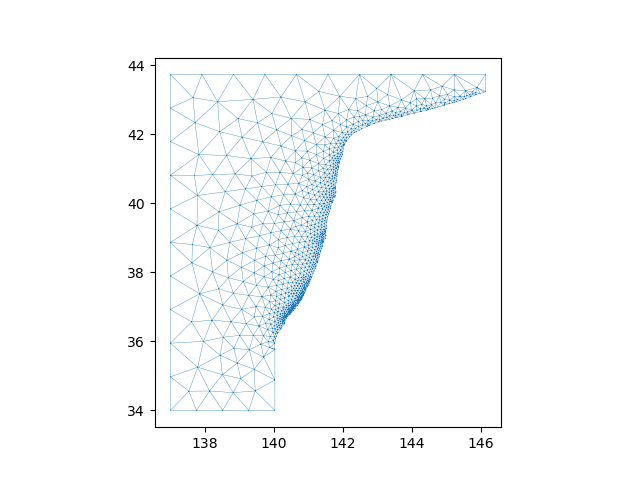

In [103]:
# Read and parse mesh
horiz = dict()
# information about the CMI mesh is read in, and stored in a dictionary just like for fault mesh earlier
horizobj = meshio.read("horiz.msh") 
horiz["points"] = horizobj.points
horiz["verts"] = meshio.CellBlock("triangle", horizobj.get_cells_type("triangle")).data

keep_el = np.ones(len(horiz["verts"])).astype(bool)

for i in range(len(horiz["verts"])):
    tri_test = np.shape(np.unique(horiz["points"][horiz["verts"][i,:],:],axis=0))[0]
    if tri_test != 3:
        keep_el[i] = False

horiz["verts"] = horiz["verts"][keep_el,:]

# Expand mesh coordinates
horiz["lon1"] = horiz["points"][horiz["verts"][:, 0], 0]
horiz["lon2"] = horiz["points"][horiz["verts"][:, 1], 0]
horiz["lon3"] = horiz["points"][horiz["verts"][:, 2], 0]
horiz["lat1"] = horiz["points"][horiz["verts"][:, 0], 1]
horiz["lat2"] = horiz["points"][horiz["verts"][:, 1], 1]
horiz["lat3"] = horiz["points"][horiz["verts"][:, 2], 1]
horiz["dep1"] = horiz["points"][horiz["verts"][:, 0], 2]
horiz["dep2"] = horiz["points"][horiz["verts"][:, 1], 2]
horiz["dep3"] = horiz["points"][horiz["verts"][:, 2], 2]
horiz["centroids"] = np.mean(horiz["points"][horiz["verts"], :], axis=1)

# Cartesian coordinates in meters
horiz["x1"], horiz["y1"], horiz["z1"] = sph2cart(
    horiz["lon1"],
    horiz["lat1"],
    RADIUS_EARTH + KM2M * horiz["dep1"],
)
horiz["x2"], horiz["y2"], horiz["z2"] = sph2cart(
    horiz["lon2"],
    horiz["lat2"],
    RADIUS_EARTH + KM2M * horiz["dep2"],
)
horiz["x3"], horiz["y3"], horiz["z3"] = sph2cart(
    horiz["lon3"],
    horiz["lat3"],
    RADIUS_EARTH + KM2M * horiz["dep3"],
)
# Cartesian triangle centroids
horiz["x_centroid"] = (horiz["x1"] + horiz["x2"] + horiz["x3"]) / 3.0
horiz["y_centroid"] = (horiz["y1"] + horiz["y2"] + horiz["y3"]) / 3.0
horiz["z_centroid"] = (horiz["z1"] + horiz["z2"] + horiz["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(horiz["lon2"] - horiz["lon1"]), np.deg2rad(horiz["lat2"] - horiz["lat1"]), (1 + KM2M * horiz["dep2"] / RADIUS_EARTH) - (1 + KM2M * horiz["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(horiz["lon3"] - horiz["lon1"]), np.deg2rad(horiz["lat3"] - horiz["lat1"]), (1 + KM2M * horiz["dep3"] / RADIUS_EARTH) - (1 + KM2M * horiz["dep1"] / RADIUS_EARTH)])
horiz["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(horiz["nv"][:, 0], horiz["nv"][:, 1], horiz["nv"][:, 2])
horiz["strike"] = wrap2360(-np.rad2deg(azimuth))
horiz["dip"] = 90 - np.rad2deg(elevation)
horiz["dip_flag"] = horiz["dip"] != 90

# Draw the fault 
fig, ax = plt.subplots()
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.set_aspect("equal")
plt.show()

In [ ]:
# there are 6 possibilities for mesh plane intersection of the triangles
# given 3 nodes [a,b,c], where T is above and F is below the clipping plane, 
# [TFF], [TTF], [TFT], [FTF], [FFT], [FTT]
# these possibilities are numbered 1 through 6
# if 1: keep node a, and add points along ab and ac calculated from the depth contour
# if 2: [a, bc, ac] [a, b, ac]
# if 3: [a, bc, ab] [a, c, bc]
# if 4: [b, ab, bc]
# if 5: [c, ac, bc]
# if 6: [b, ac, ab] [b, c, ac]


# add new points calculated along line segments to the old points
df = pd.DataFrame(depth_all, columns=["lon", "lat", "dep"])
depth_contour = df.drop_duplicates(subset=["lon"])
depth_contour = np.array(depth_contour.drop_duplicates(subset="lat")) # order of elements determined by order of tri_elem, not sorted

num_old = len((mesh["points"][:,0]))
new_points = np.empty(((num_old + len(depth_contour[:,0])), 3))

# add the old points as well as the new points to a shared array, contains points deeper than needed for now
new_points[0:num_old, 0] = mesh["points"][:, 0]
new_points[0:num_old, 1] = mesh["points"][:, 1]
new_points[0:num_old, 2] = mesh["points"][:, 2]
new_points[num_old:, 0] = depth_contour[:,0]
new_points[num_old:, 1] = depth_contour[:,1]
new_points[num_old:, 2] = -1*depth_contour[:,2] # negative to match previous convention for points

points_beg_idx = num_old # beginning of the new points calculated for depth contour

# determine the combination possibility that each element is
combo_list = np.empty((len(tri_elem[:,0]), 3))
num_extra = 0

for j in range(np.size(tri_elem, 0)):
    a = tri_elem[j,[0,1,2]] #node a
    b = tri_elem[j,[3,4,5]] #node b
    c = tri_elem[j,[6,7,8]] #node c

    # determine the combination of nodes above and below the CMI plane
    combo = [bool(a[2]<plane_depth), bool(b[2]<plane_depth), bool(c[2]<plane_depth)]
    combo_list[j,0] = combo[0]
    combo_list[j,1] = combo[1]
    combo_list[j,2] = combo[2]

    if sum(combo)==2: # if more than two nodes are above the CMI depth, the remaining shape is a quadrilateral and two triangles must be created from it
        num_extra += 1

# create array of new triangle elements
new_tri_elem = np.zeros(((len(tri_elem[:,0])+num_extra), 9)) # as many as previously plus the new ones
point_count = 0
tri_count = 0

for i in range(len(combo_list[:,0])):
    temp_list = [combo_list[i,0], combo_list[i,1], combo_list[i,2]]

    if temp_list==[True,False,False]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i,[0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add ac
        tri_count += 1
    elif temp_list==[True,True,False]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i,[0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add ac
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add bc
        tri_count += 1
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count-1, [0,1,2]] # add node ac
        tri_count += 1
    elif temp_list==[True,False,True]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node bc
        tri_count += 1
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [0,1,2]] # keep node a
        new_tri_elem[tri_count, [3,4,5]] = tri_elem[i, [6,7,8]] # keep node c
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count-1, [0,1,2]] # add node bc
        tri_count += 1
    elif temp_list==[False,True,False]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node bc
        tri_count += 1
    elif temp_list==[False,False,True]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [6,7,8]] # keep node c
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ac
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node bc
        tri_count += 1
    elif temp_list==[False,True,True]:
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [3,4,5]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ab
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count, [0,1,2]] ; point_count += 1 # add node ac
        tri_count += 1
        new_tri_elem[tri_count, [0,1,2]] = tri_elem[i, [3,4,5]] # keep node b
        new_tri_elem[tri_count, [3,4,5]] = tri_elem[i, [6,7,8]] # keep node c
        new_tri_elem[tri_count, [6,7,8]] = depth_all[point_count-1, [0,1,2]] # add node ac
        tri_count += 1
    else:
        print("PROBLEEEEEM")


#depth val of new_tri_elem needs to be negative to match the points
new_tri_elem[:,[2,5,8]] = -1*new_tri_elem[:,[2,5,8]]

new_verts = np.empty((len(new_tri_elem[:,0]), 3))

# for row in new_tri_elem, [0,1,2] [3,4,5] [6,7,8]
# np.where(new_points[:, [0,1,2]] == node)
# new_verts[i, 0] = index

for m in range(len(new_tri_elem[:,0])):
    # for node 1
    points = np.round(new_points, decimals=9)
    lon1 = round(new_tri_elem[m,0], 9) ; lat1 = round(new_tri_elem[m,1], 9) ; dep1 = round(new_tri_elem[m,2], 9)
    lon2 = round(new_tri_elem[m,3], 9) ; lat2 = round(new_tri_elem[m,4], 9) ; dep2 = round(new_tri_elem[m,5], 9)
    lon3 = round(new_tri_elem[m,6], 9) ; lat3 = round(new_tri_elem[m,7], 9) ; dep3 = round(new_tri_elem[m,8], 9)
    index1 = np.where((points[:,0]==lon1) & (points[:,1]==lat1) & (points[:,2]==dep1))[0]
    index2 = np.where((points[:,0]==lon2) & (points[:,1]==lat2) & (points[:,2]==dep2))[0]
    index3 = np.where((points[:,0]==lon3) & (points[:,1]==lat3) & (points[:,2]==dep3))[0]
    new_verts[m,0] = int(index1[0])
    new_verts[m,1] = int(index2[0])
    new_verts[m,2] = int(index3[0])


# bool mask was earlier defined to grab elem spanning the depth contour, now it needs to be reversed
flip_bool = ~bool_mask
old_verts = mesh["verts"][flip_bool]

# find points that are lower than the depth contour
too_deep = np.where(new_points[:,2] < -60)[0] # rows of points that have values too deep
big_mask = np.isin(old_verts, too_deep, invert=True)
mask = []
for n in range(len(big_mask[:,0])):
    if big_mask[n].all():
        mask.append(True)
    else:
        mask.append(False)

mask = np.array(mask)

useful_verts = np.empty((np.sum(mask),3))
print(np.shape(useful_verts))
useful_verts[::] = old_verts[::][mask]

new_verts = new_verts.astype(int) # switch from float so that the indecies are compatible
total_verts = np.vstack((useful_verts, new_verts))

cells = {"triangle" }

fault = meshio.Mesh(np.array(new_points), cells)
meshio.write("clipped_fault.vtu", fault)


# # find old verts corresponding to tri_elem and modify them to reference the new points
# # new points begin at # points_beg_idx

# # delete elements whose points extend beyond 60 km depth


# new centroids, normal vectors, cartesian coordinates, and areas will need to be calculated for these elements

(1832, 3)


AttributeError: 'str' object has no attribute 'type'

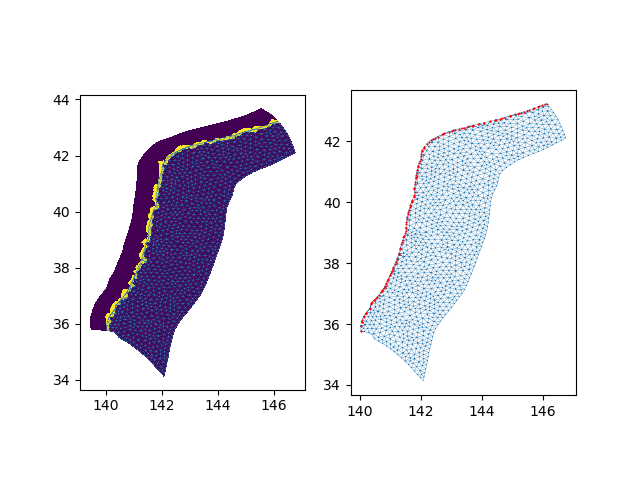

In [141]:
fault = {}
fault["points"] = new_points
fault["verts"] = total_verts.astype(int)

# Expand mesh coordinates
fault["lon1"] = fault["points"][fault["verts"][:, 0], 0]
fault["lon2"] = fault["points"][fault["verts"][:, 1], 0]
fault["lon3"] = fault["points"][fault["verts"][:, 2], 0]
fault["lat1"] = fault["points"][fault["verts"][:, 0], 1]
fault["lat2"] = fault["points"][fault["verts"][:, 1], 1]
fault["lat3"] = fault["points"][fault["verts"][:, 2], 1]
fault["dep1"] = fault["points"][fault["verts"][:, 0], 2]
fault["dep2"] = fault["points"][fault["verts"][:, 1], 2]
fault["dep3"] = fault["points"][fault["verts"][:, 2], 2]
fault["centroids"] = np.mean(fault["points"][fault["verts"], :], axis=1)

# Cartesian coordinates in meters
fault["x1"], fault["y1"], fault["z1"] = sph2cart(
    fault["lon1"],
    fault["lat1"],
    RADIUS_EARTH + KM2M * fault["dep1"],
)
fault["x2"], fault["y2"], fault["z2"] = sph2cart(
    fault["lon2"],
    fault["lat2"],
    RADIUS_EARTH + KM2M * fault["dep2"],
)
fault["x3"], fault["y3"], fault["z3"] = sph2cart(
    fault["lon3"],
    fault["lat3"],
    RADIUS_EARTH + KM2M * fault["dep3"],
)
# Cartesian triangle centroids
fault["x_centroid"] = (fault["x1"] + fault["x2"] + fault["x3"]) / 3.0
fault["y_centroid"] = (fault["y1"] + fault["y2"] + fault["y3"]) / 3.0
fault["z_centroid"] = (fault["z1"] + fault["z2"] + fault["z3"]) / 3.0

# Cross products for orientations
tri_leg1 = np.transpose([np.deg2rad(fault["lon2"] - fault["lon1"]), np.deg2rad(fault["lat2"] - fault["lat1"]), (1 + KM2M * fault["dep2"] / RADIUS_EARTH) - (1 + KM2M * fault["dep1"] / RADIUS_EARTH)])
tri_leg2 = np.transpose([np.deg2rad(fault["lon3"] - fault["lon1"]), np.deg2rad(fault["lat3"] - fault["lat1"]), (1 + KM2M * fault["dep3"] / RADIUS_EARTH) - (1 + KM2M * fault["dep1"] / RADIUS_EARTH)])
fault["nv"] = np.cross(tri_leg1, tri_leg2)
azimuth, elevation, r = cart2sph(fault["nv"][:, 0], fault["nv"][:, 1], fault["nv"][:, 2])
fault["strike"] = wrap2360(-np.rad2deg(azimuth))
fault["dip"] = 90 - np.rad2deg(elevation)
fault["dip_flag"] = fault["dip"] != 90

# Draw the fault 
plt.close('all')

fig, ax = plt.subplots(1, 2)
ax[0].tripcolor(mesh["points"][:, 0], mesh["points"][:, 1], mesh["verts"], linewidth=0.25, facecolors=bool_mask)
ax[0].triplot(fault["points"][:,0], fault["points"][:,1], fault["verts"], linewidth=0.25)
ax[0].set_aspect("equal")

ax[1].triplot(fault["points"][:,0], fault["points"][:,1], fault["verts"], linewidth=0.25)
ax[1].scatter(depth_contour[:,0], depth_contour[:,1], s=0.1, marker='*', color = 'r')
ax[1].set_aspect("equal")
plt.show()

#### Read in GPS data

In [129]:
colnames = ["station_ID", 'lon', 'lat', 'east_vel', 'north_vel', 'up_vel']
gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)

# Place stations into single array
# lat, lon, dep, but dep is always zero because they're on the ground
# reshape(3, -1) means put it into 3 rows and as many columns as data points
# then T makes it 3 columns, and as many rows as data points
obsv = np.array([gps.lon, gps.lat, 0*gps.lat]).reshape((3, -1)).T.copy()

vec_scale = 2500

plot_vectors = False
plt.close('all')
if plot_vectors:
    fig, ax = plt.subplots()
    ax.quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale)
    ax.axis("equal")
    plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7c/8db84z1953v2yvj0hb957l_h0000gp/T/ipykernel_49152/3619376764.py:2: SyntaxWarning: invalid escape sequence '\s'
  gps = pd.read_table("./cumulative_disp.txt", sep='\s+', header=None, names=colnames)


### Concatenate Meshes and calculate partial derivatives

In [130]:
import sys
sys.path.append('/Users/anitamiddleton/Documents/python/celeri')

import celeri 
from dataclasses import dataclass

# Force meshes into dataclass, using existing fields
class Mesh:
    def __init__(self, d=None):
        if d is not None:
            for key, value in d.items():
                setattr(self, key, value)

# List of classes
meshes = [Mesh(fault), Mesh(horiz)]

# Quick config class
@dataclass
class Config:
    material_lambda = 30000000000
    material_mu = 30000000000
config = Config()

# Define indices for meshes in arrays, where each meshes triangle elements begin
n_tri = np.zeros(len(meshes), dtype=int)
for i in range(len(meshes)):
    n_tri[i] = len(meshes[i].lon1)
tri_end_idx = np.cumsum(n_tri) # the last triangle index, the sum of all triangle elem in both meshes
tri_beg_idx = [0, tri_end_idx[0]] # list of indexes, the beginning of the fault mesh elem, beginning of the cmi mesh elem
total_n_tri = tri_end_idx[-1] 
# gets the last element of the summation that makes up total triangles, here, the number of tri elem in the CMI

# Allocate space for slip-to-displacement array
disp_mat = np.zeros((3*len(gps.lon), 3*np.sum(n_tri)))
# Allocate space for slip-to-displacement array
smoothing_mat = np.zeros((3*np.sum(n_tri), 3*np.sum(n_tri)))

# For each mesh, fill in disp_mat with the values and not just zeros
for mesh_idx in range(len(meshes)):
    # Calculate slip to displacement partials, using geographic coordinates
    disp_mat[:, 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = celeri.spatial.get_tde_to_velocities_single_mesh(meshes, gps, config, mesh_idx)
    # Get smoothing operator

    # Indices of shared sides in this mesh
    share = celeri.spatial.get_shared_sides(meshes[mesh_idx].verts)
    # Distances between centroids of shared elements
    tri_shared_sides_distances = celeri.spatial.get_tri_shared_sides_distances(
            share,
            meshes[mesh_idx].x_centroid,
            meshes[mesh_idx].y_centroid,
            meshes[mesh_idx].z_centroid,
        )
    # Distance-scaled smoothing matrix
    smat = celeri.spatial.get_tri_smoothing_matrix(
            share, tri_shared_sides_distances
        )
    # Insert sparse matrix into full array
    smoothing_mat[3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx], 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = smat.toarray()
    # Get smoothing operator

    # Indices of shared sides in this mesh
    # find which triangles share sides with which triangles, because in a group, 
    # general idea: one triangle gets 3, other three around it get -1, end result after summation is smooth
    share = celeri.spatial.get_shared_sides(meshes[mesh_idx].verts)
    # Distances between centroids of shared elements
    tri_shared_sides_distances = celeri.spatial.get_tri_shared_sides_distances(
            share,
            meshes[mesh_idx].x_centroid,
            meshes[mesh_idx].y_centroid,
            meshes[mesh_idx].z_centroid,
        )
    # Distance-scaled smoothing matrix
    smat = celeri.spatial.get_tri_smoothing_matrix(
            share, tri_shared_sides_distances
        )
    # Insert sparse matrix into full array
    smoothing_mat[3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx], 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = smat.toarray()

Calculating cutde partials for triangles: 100%|██████████| 1681/1681 [00:01<00:00, 903.32it/s]


##### Mini test to check for flattened elements

In [ ]:
# test if elem are line elem instead of triangle 

bad_cols = np.isnan(disp_mat[0,:])
bad_el = int(np.where(bad_cols)[0][0]/3)

thing = bad_el - tri_beg_idx[1]
print(np.shape(np.unique(horiz["points"][horiz["verts"][thing,:],:],axis=0))[0])
print(horiz["verts"][thing,:])

# Draw the fault 
fig, ax = plt.subplots()
ax.triplot(horiz["points"][:, 0], horiz["points"][:, 1], horiz["verts"], linewidth=0.25)
ax.plot(horiz["centroids"][thing,0], horiz["centroids"][thing,1], "*r")
ax.set_aspect("equal")
plt.show()

#### Assemble matrices, weighting vector, and data vector

In [131]:
# Assemble matrices

assembled_mat = np.vstack([disp_mat, smoothing_mat]) # stick constraint array as 3rd argument

# List of smoothing weights to test
smooths = [1e-16, 1e-6, 1e-2, 1e-1, 1, 10, 100, 1000, 1e6, 1e9, 1e16]

# Select a smoothing weight and apply to meshes
smoothing_weight = smooths[8]
if np.size(smoothing_weight) != len(meshes):
    smoothing_weight = smoothing_weight*np.ones(len(meshes)) 

# Assemble weighting vector
# Allocate space for data vector
data_vector = np.zeros((np.shape(assembled_mat)[0], 1)) # by default, the rows corresponding to constraint array are initialized as zeros
# Vector of displacements
disp_array = np.array([gps.east_vel, gps.north_vel, gps.up_vel]).reshape((3,-1)).T.copy()
data_vector[0:np.size(disp_array)] = disp_array.flatten().reshape(-1,1)

# Start with unit uncertainties 
# this puts the smoothing weight for the fault mesh and cmi mesh, and leaves gps stations as 1
weights = np.ones((np.shape(assembled_mat)[0], 1)) # might want to update when adding slip constraint
for mesh_idx in range(len(meshes)):
    weights[np.size(disp_array)+ 3*tri_beg_idx[mesh_idx]:3*tri_end_idx[mesh_idx]] = smoothing_weight[mesh_idx]

#### Perform inversion

In [132]:
# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

# Estimate slip using pre-calculated covariance
est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
# Predict displacement at stations
pred_disp = disp_mat.dot(est_slip)

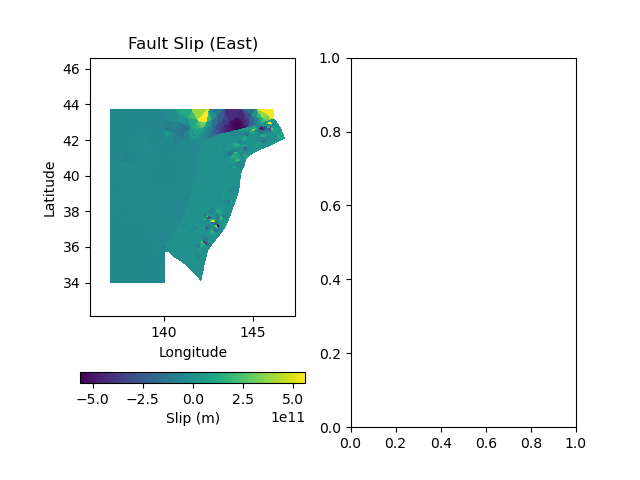

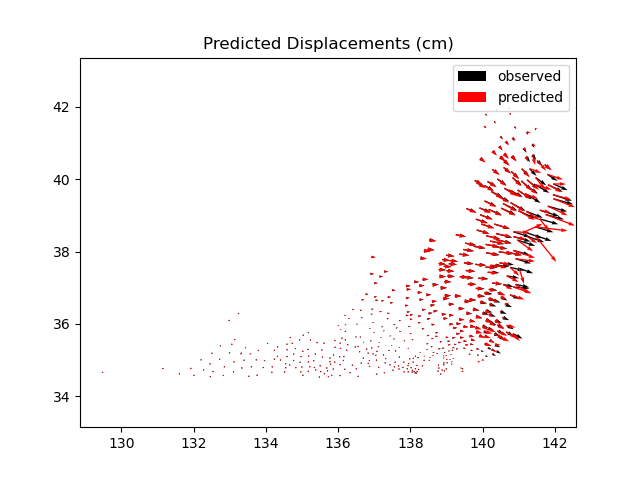

In [133]:
# plot for visualizing
vec_scale = 2500
plt.close('all')
end_idx = 3*tri_end_idx[0] #end of fault elem beginning of cmi elem

max_mag = np.abs(np.max(est_slip[1::3]))
max_mag_f = np.abs(np.max(est_slip[1:end_idx:3]))
max_mag_h = np.abs(np.max(est_slip[end_idx::3]))/100

fig, ax = plt.subplots(1, 2)
rso = ax[0].tripcolor(fault["points"][:,0], fault["points"][:,1], fault["verts"], 
                      facecolors=(est_slip[1:end_idx:3]).flatten(), vmin=-max_mag_f, vmax=max_mag_f)
ax[0].tripcolor(horiz["points"][:,0], horiz["points"][:,1], horiz["verts"], facecolors=(est_slip[end_idx::3]/100).flatten())
cbar1 = fig.colorbar(rso, ax=ax[0], orientation='horizontal')
cbar1.set_label("Slip (m)")
ax[0].set(xlim=(xmin-2, xmax), ylim=(ymin, ymax), aspect='equal')
ax[0].title.set_text("Fault Slip (East)") #graph 1
ax[0].set_ylabel("Latitude")
ax[0].set_xlabel("Longitude")
plt.show()


rso = ax[1].tripcolor(horiz["points"][:,0], horiz["points"][:,1], horiz["verts"], facecolors=(est_slip[end_idx+1::3]/100).flatten(), vmin=-max_mag_h, vmax=max_mag_h)
cbar1 = fig.colorbar(rso, ax=ax[1], orientation='horizontal')
cbar1.set_label("Slip (m)")
#ax[1].quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r', label="predicted")
#ax[1].quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
ax[1].set(xlim=(xmin-2, xmax), ylim=(ymin, ymax), aspect='equal')
ax[1].title.set_text("CMI Slip (East)") #graph 1
ax[1].set_ylabel("Latitude")
ax[1].set_xlabel("Longitude")


fig, ax = plt.subplots()
ax.quiver(gps.lon, gps.lat, gps.east_vel, gps.north_vel, scale=vec_scale, color='k', label='observed')
ax.quiver(gps.lon, gps.lat, pred_disp[0::3], pred_disp[1::3], scale=vec_scale, color='r', label="predicted")
#ax.quiver(gps.lon, gps.lat, data_vector[0:1497:3], data_vector[1:1497:3], scale=vec_scale, color='b')
ax.axis("equal")
plt.title("Predicted Displacements (cm)")
plt.legend()
plt.show()